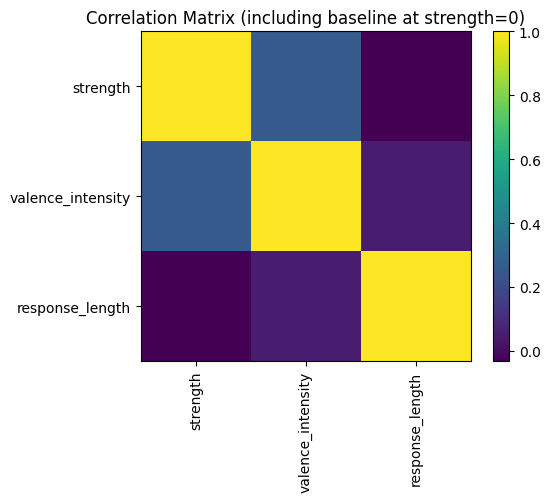

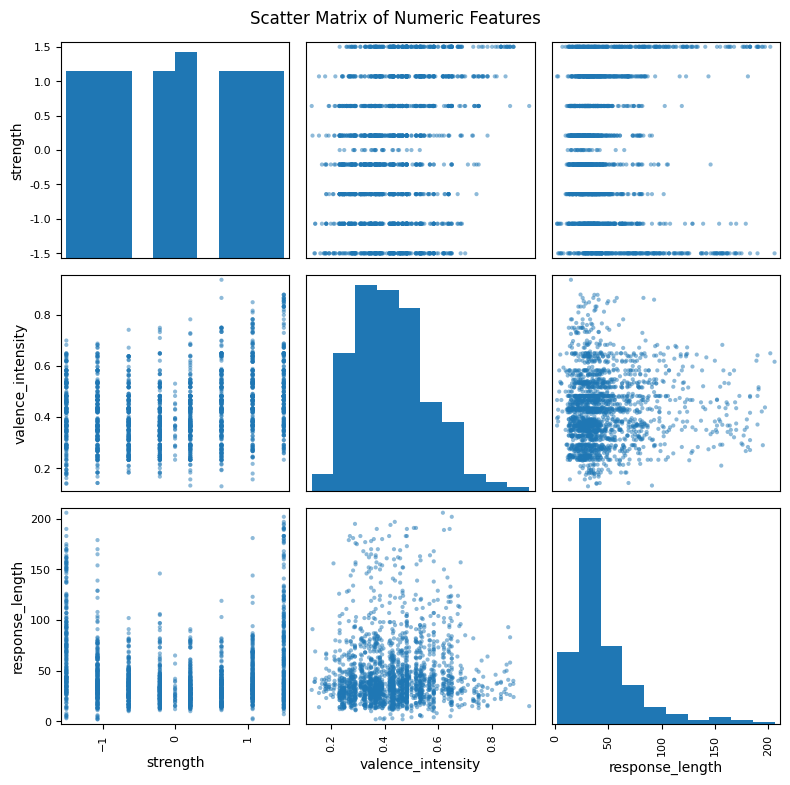

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import statsmodels.api as sm

# ─── 1) Load & Prepare ───────────────────────────────────────────────────────
# Main data
df_main = pd.read_excel('/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/Valence/Small2k.xlsx')
df_main['response_length'] = df_main['response'].str.split().str.len()

# Baseline data (treat as strength=0)
df_baseline = pd.read_excel('/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/data/baseline_answers002.xlsx')
df_baseline['response_length'] = df_baseline['response'].str.split().str.len()
df_baseline['strength'] = 0

# Make sure both have the same columns (add any missing columns to baseline as NaN)
for col in df_main.columns:
    if col not in df_baseline.columns:
        df_baseline[col] = pd.NA

# Concat
df = pd.concat([df_baseline, df_main], ignore_index=True, sort=False)

# ─── 2) Correlation Matrix & Scatter Matrix ─────────────────────────────────
numeric = df[['strength','valence_intensity','response_length']]
corr = numeric.corr()

# Correlation heatmap
plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect='equal')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix (including baseline at strength=0)')
plt.tight_layout()
plt.show()

# Scatter‐matrix
scatter_matrix(numeric, diagonal='hist', alpha=0.5, figsize=(8,8))
plt.suptitle('Scatter Matrix of Numeric Features')
plt.tight_layout()
plt.show()


# ─── 3) K-Means Clustering (k=3) ────────────────────────────────────────────
X = numeric.values
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df['cluster'] = kmeans.labels_

plt.figure(figsize=(6,5))
plt.scatter(df['strength'], df['valence_intensity'], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('Strength')
plt.ylabel('Valence Intensity')
plt.title('K-Means Clusters (k=3) — baseline = 0')
plt.tight_layout()
plt.show()


# ─── 4) Violin Plot: Valence by Question (incl. baseline) ──────────────────
questions = sorted(df['question_index'].dropna().unique())
groups = [df[df['question_index']==q]['valence_intensity'].values for q in questions]

plt.figure(figsize=(12,6))
plt.violinplot(groups, positions=questions, showmeans=True)
plt.xlabel('Question Index')
plt.ylabel('Valence Intensity')
plt.title('Violin Plot of Valence by Question (baseline entries all go to strength=0)')
plt.tight_layout()
plt.show()


# ─── 5) Word-Clouds by Strength Level (0…max) ───────────────────────────────
for strength in sorted(df['strength'].unique()):
    subset = df[df['strength']==strength]
    text = " ".join(subset['response'].dropna())
    if not text.strip():
        continue
    wc = WordCloud(width=400, height=200).generate(text)
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    lbl = "baseline (0)" if strength==0 else f"{strength}"
    plt.title(f'Word Cloud — Strength {lbl}')
    plt.tight_layout()
    plt.show()


# ─── 6) Regression: Valence ~ Strength (incl. baseline) ─────────────────────
X_lr = sm.add_constant(df['strength'])
y = df['valence_intensity']
model = sm.OLS(y, X_lr, missing='drop').fit()
print(model.summary())

# Plot with both actual + baseline
plt.figure(figsize=(6,5))
plt.scatter(df['strength'], df['valence_intensity'], alpha=0.5)
xs = pd.Series(sorted(df['strength'].unique()))
ys = model.params['const'] + model.params['strength'] * xs
plt.plot(xs, ys, linewidth=2, color='C2')
plt.xlabel('Strength')
plt.ylabel('Valence Intensity')
plt.title('Regression: Valence ~ Strength (baseline included at 0)')
plt.tight_layout()
plt.show()


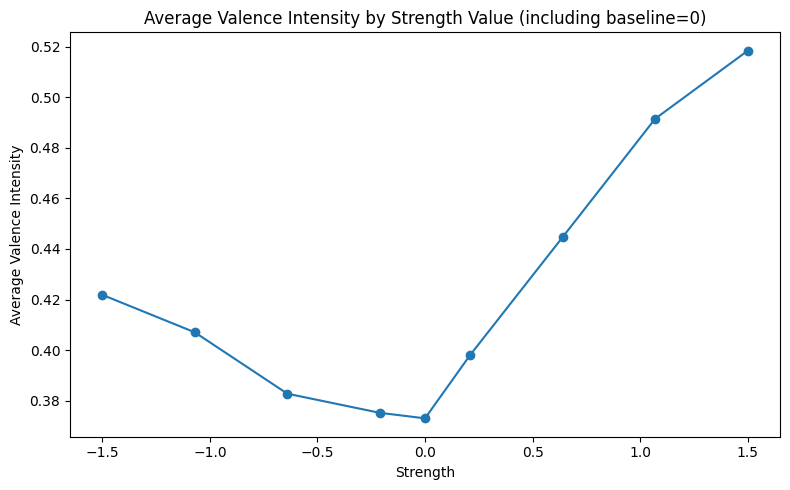

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths
main_path    = '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/Valence/Small2k.xlsx'
baseline_path= '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/data/baseline_answers002.xlsx'

# Load datasets
df_main = pd.read_excel(main_path)
df_base = pd.read_excel(baseline_path)

# Tag baseline as strength=0
df_base['strength'] = 0

# Combine
df = pd.concat([df_base, df_main], ignore_index=True, sort=False)

# Compute average valence by each actual strength value (0…max)
avg_by_strength = (
    df
    .groupby('strength')['valence_intensity']
    .mean()
    .reset_index()
    .sort_values('strength')
)

# Plot: Average Valence Intensity vs. Strength
plt.figure(figsize=(8, 5))
plt.plot(avg_by_strength['strength'], avg_by_strength['valence_intensity'], marker='o')
plt.title('Average Valence Intensity by Strength Value (including baseline=0)')
plt.xlabel('Strength')
plt.ylabel('Average Valence Intensity')
plt.tight_layout()
plt.show()


Avg Valence Intensity by Strength:
    strength  valence_intensity
0     -1.50           0.421880
1     -1.07           0.407068
2     -0.64           0.382824
3     -0.21           0.375256
4      0.00           0.373080
5      0.21           0.398128
6      0.64           0.444720
7      1.07           0.491484
8      1.50           0.518348


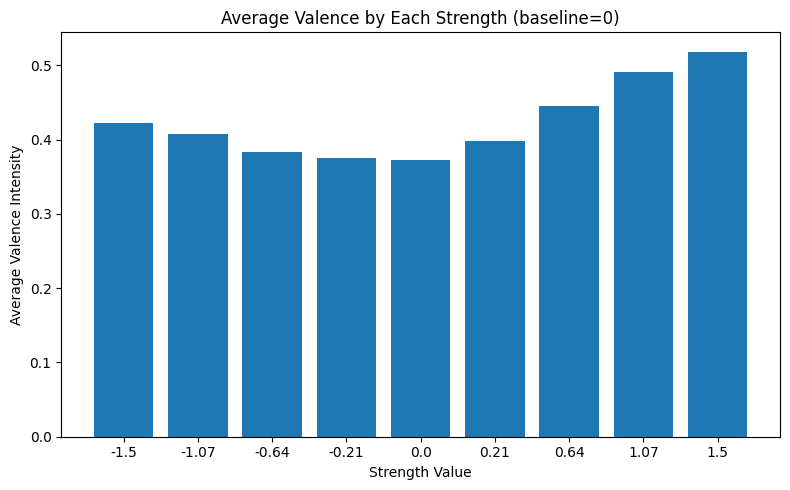


Valence Intensity by Question × Strength:
 strength        -1.50  -1.07  -0.64  -0.21   0.00   0.21   0.64   1.07   1.50
question_index                                                               
1               0.363  0.364  0.352  0.307  0.316  0.313  0.447  0.416  0.502
2               0.376  0.398  0.327  0.347  0.367  0.351  0.320  0.479  0.508
3               0.413  0.413  0.414  0.362  0.250  0.398  0.424  0.521  0.516
4               0.405  0.384  0.422  0.335  0.364  0.414  0.489  0.560  0.510
5               0.426  0.363  0.381  0.321  0.362  0.405  0.412  0.503  0.523
6               0.452  0.312  0.345  0.330  0.324  0.330  0.417  0.485  0.538
7               0.400  0.382  0.369  0.303  0.391  0.396  0.479  0.453  0.522
8               0.452  0.376  0.376  0.326  0.328  0.378  0.428  0.471  0.536
9               0.473  0.475  0.436  0.432  0.396  0.505  0.540  0.540  0.548
10              0.350  0.401  0.372  0.363  0.283  0.362  0.428  0.505  0.540
11              0.42

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths
main_path     = '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/Valence/Small2k.xlsx'
baseline_path = '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/data/baseline_answers002.xlsx'

# Load & prepare
df_main = pd.read_excel(main_path)
df_base = pd.read_excel(baseline_path)
df_base['strength'] = 0

# Concat
df = pd.concat([df_base, df_main], ignore_index=True, sort=False)

# 2) Compute average valence for each of the 8+1 strength values
avg_by_strength = (
    df
    .groupby('strength')['valence_intensity']
    .mean()
    .reset_index()
    .sort_values('strength')
)

print("Avg Valence Intensity by Strength:\n", avg_by_strength)

# 3) Plot it as a bar chart
plt.figure(figsize=(8,5))
plt.bar(avg_by_strength['strength'].astype(str), avg_by_strength['valence_intensity'])
plt.xlabel('Strength Value')
plt.ylabel('Average Valence Intensity')
plt.title('Average Valence by Each Strength (baseline=0)')
plt.tight_layout()
plt.show()

# 4) (Optional) Breakdown by question × strength
pivot = df.pivot_table(
    index='question_index',
    columns='strength',
    values='valence_intensity',
    aggfunc='mean'
)
print("\nValence Intensity by Question × Strength:\n", pivot.round(3))


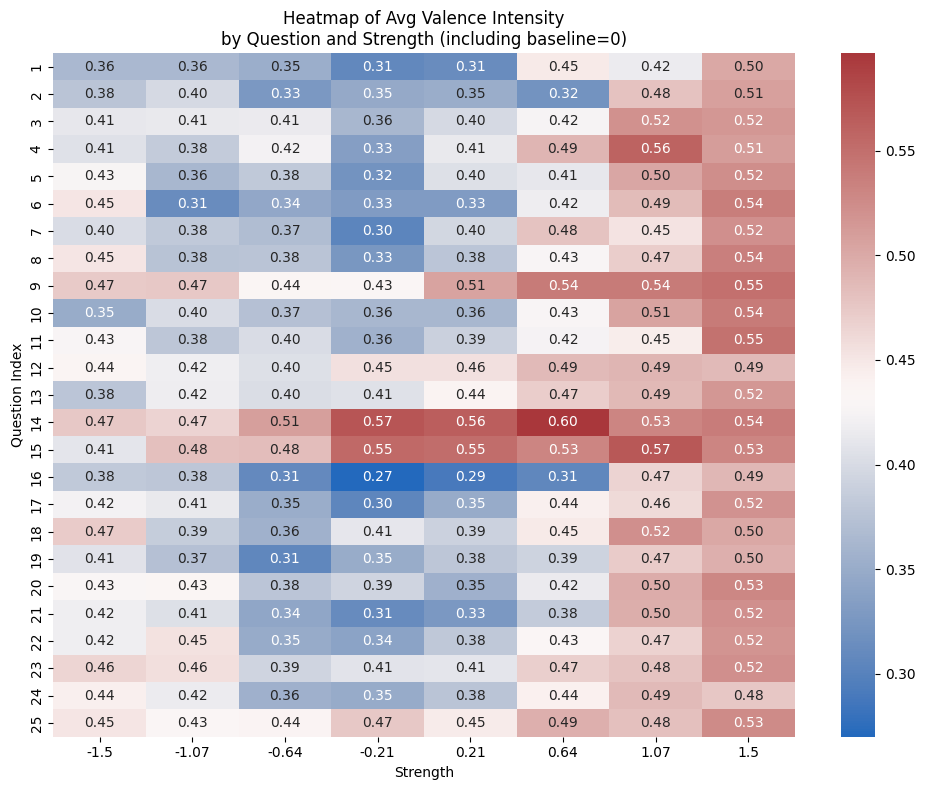

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
main_path     = '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/Valence/Small2k.xlsx'
baseline_path = '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/data/baseline_answers002.xlsx'

# Load & combine
df_main = pd.read_excel(main_path)
df_base = pd.read_excel(baseline_path)
df_base['strength'] = 0
df = pd.concat([df_base, df_main], ignore_index=True, sort=False)

# Pivot: questions × strength (0…max)
pivot = df.pivot_table(
    index='question_index',
    columns='strength',
    values='valence_intensity',
    aggfunc='mean'
).sort_index()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="vlag")
plt.title("Heatmap of Avg Valence Intensity\nby Question and Strength (including baseline=0)")
plt.xlabel("Strength")
plt.ylabel("Question Index")
plt.tight_layout()
plt.show()


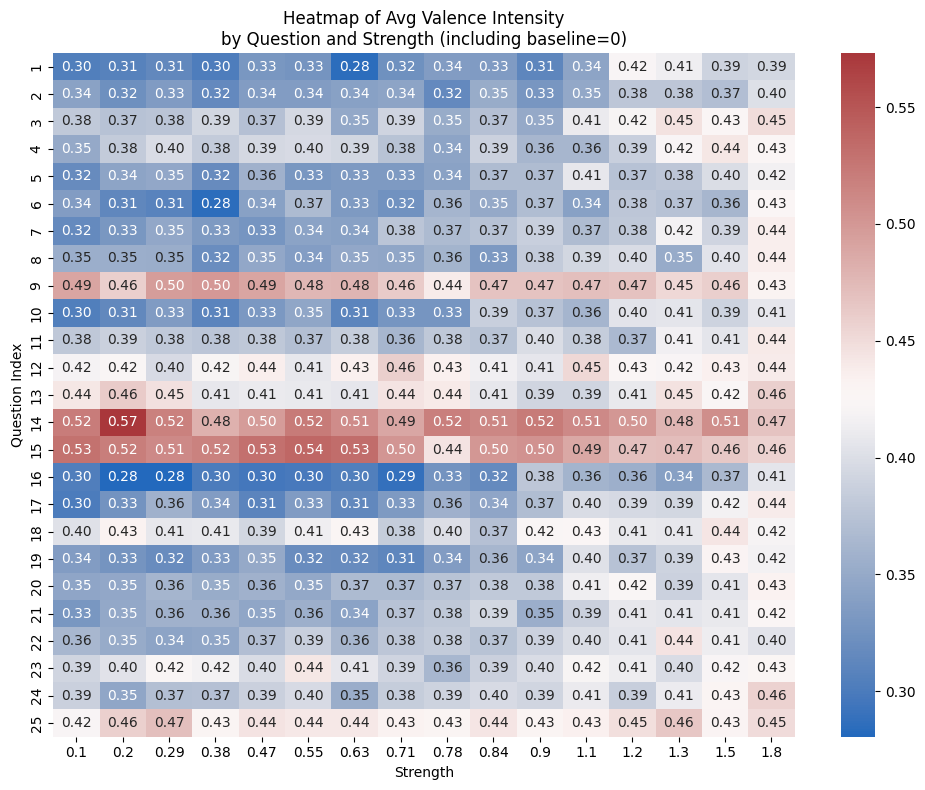

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
main_path     = '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/data/cognitive_experiment_results007_big.xlsx'
# baseline_path = '/home/koalacrown/Desktop/Code/Projects/LLM_threapy/LLM_agumented_therapy/Cogexp/Valence/cognitive_experiment_results005addon.xlsx'

# Load & combine
df_main = pd.read_excel(main_path)
# df_base = pd.read_excel(baseline_path)
# df_base['strength'] = 0
# df = pd.concat([df_base, df_main], ignore_index=True, sort=False)

# Pivot: questions × strength (0…max)
pivot = df.pivot_table(
    index='question_index',
    columns='strength',
    values='valence_intensity',
    aggfunc='mean'
).sort_index()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="vlag")
plt.title("Heatmap of Avg Valence Intensity\nby Question and Strength (including baseline=0)")
plt.xlabel("Strength")
plt.ylabel("Question Index")
plt.tight_layout()
plt.show()
